In [1]:
import glob
import random
from pathlib import Path
import pickle
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import shutil


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
%%capture
!unzip /kaggle/input/dogs-vs-cats/train.zip -d /kaggle/working/

In [3]:
%%capture
!unzip /kaggle/input/dogs-vs-cats/test1.zip -d /kaggle/working/

In [15]:
for path in glob.glob('/content/dogs_vs_cats/train/* .jpg'):
    if not(os.path.exists('/content/dogs_vs_cats/train/cats') or os.path.exists('/content/dogs_vs_cats/train/dogs')):
        os.makedirs('/content/dogs_vs_cats/train/cats')
        os.makedirs('/content/dogs_vs_cats/train/dogs')
        print('Done!')

    if 'cat' in path:
        shutil.move(path, '/content/dogs_vs_cats/train/cats' + path.split('/')[-1])
    else:
        shutil.move(path, '/content/dogs_vs_cats/train/dogs' + path.split('/')[-1])


In [16]:
my_dataset = {}
for class_name in glob.glob('/content/dogs_vs_cats/train/*'):
        my_dataset[class_name.split('/')[-1]] = glob.glob(class_name + '/*')

In [17]:
print(f"These are the keys in my dataset {my_dataset.keys()}")

These are the keys in my dataset dict_keys(['dogs', 'cats'])


In [18]:
X   = my_dataset.keys()
y = [len(keys)for keys in my_dataset.values()]

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

In [20]:
print(f"The shape of my data before splitting is {y}") #There are a total of 12500 cat images and 12500 Dog images

The shape of my data before splitting is [58, 58]


In [21]:
# Having the image representation idea we can go further and try plotting some of the images
# What if we created a dataframe that has Height Width and ColorChannels and the Class or label?
# Using cv2 we can load our image properties
import cv2 as cv
help(cv.imread)

Help on built-in function imread:

imread(...)
    imread(filename[, flags]) -> retval
    .   @brief Loads an image from a file.
    .   
    .   @anchor imread
    .   
    .   The function imread loads an image from the specified file and returns it. If the image cannot be
    .   read (because of missing file, improper permissions, unsupported or invalid format), the function
    .   returns an empty matrix ( Mat::data==NULL ).
    .   
    .   Currently, the following file formats are supported:
    .   
    .   -   Windows bitmaps - \*.bmp, \*.dib (always supported)
    .   -   JPEG files - \*.jpeg, \*.jpg, \*.jpe (see the *Note* section)
    .   -   JPEG 2000 files - \*.jp2 (see the *Note* section)
    .   -   Portable Network Graphics - \*.png (see the *Note* section)
    .   -   WebP - \*.webp (see the *Note* section)
    .   -   AVIF - \*.avif (see the *Note* section)
    .   -   Portable image format - \*.pbm, \*.pgm, \*.ppm \*.pxm, \*.pnm (always supported)
    .   -   PFM 

In [22]:
def image_properties(file):
    '''Returns dimenstions for an image interms of HWD or HWC'''
    image = cv2.imread(file)
    h, w, d = image.shape
    return h, w, d

In [23]:
df = pd.DataFrame(columns=['Height',
                           'Width',
                           'Channels',
                           'Class'])

for pet_class in my_dataset.keys():
    for path in my_dataset[pet_class]:
        h, w, d = image_properties(path)
        df.loc[len(df)] = [h, w, d, pet_class]

df

,Height,Width,Channels,Class
0,218,199,3,dogs
1,266,201,3,dogs
2,342,499,3,dogs
3,499,372,3,dogs
4,333,500,3,dogs
...,...,...,...,...
111,266,400,3,cats
112,153,119,3,cats
113,218,499,3,cats
114,320,269,3,cats


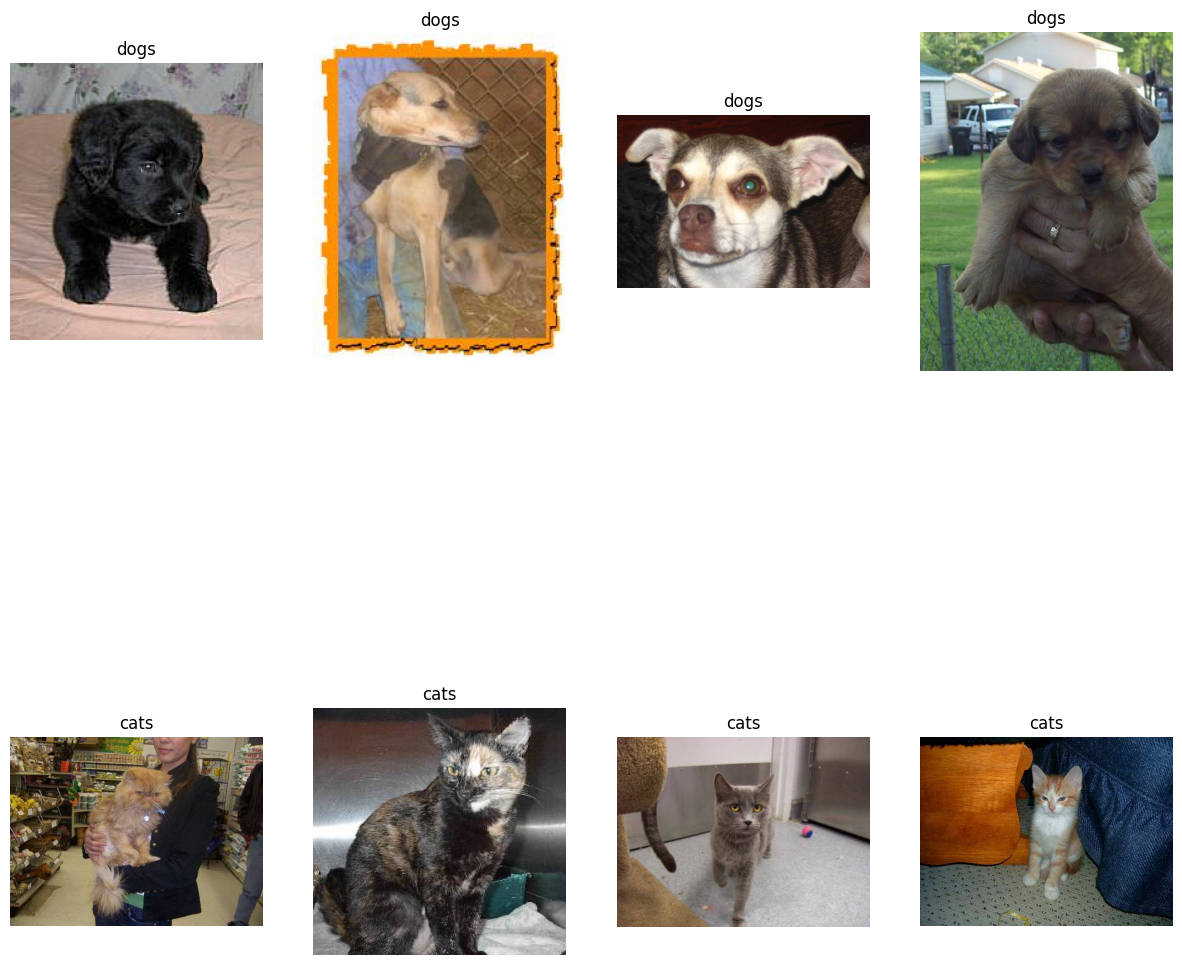

In [27]:
# How about we plot some images ? Exciting visualizations
# Lets go for some  Random Images
count = 0
plt.figure(figsize=(15, 15))
for pet_class in my_dataset.keys():
    for path in my_dataset[pet_class]:
        sp = plt.subplot(2, 4, count + 1, )
        sp.axis('Off')
        sp.set_title(pet_class)
        image = cv.imread(path)
        image = cv.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        count += 1
        if count % 4== 0:
            break
plt.show()

In [28]:
from sklearn.preprocessing import LabelEncoder
lbl_encoder = LabelEncoder()
df['Class'] = lbl_encoder.fit_transform(df['Class'])

In [29]:
df.head()

,Height,Width,Channels,Class
0,218,199,3,1
1,266,201,3,1
2,342,499,3,1
3,499,372,3,1
4,333,500,3,1


In [30]:
df['Class'].value_counts().head()

,count
Class,
1,58
0,58


In [31]:
# Selecting  feature and target variable
from sklearn.model_selection import train_test_split
X =  df.drop(['Class'],axis=1)
y = df['Class']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=101)

In [32]:
X_train.shape, y_train.shape

((92, 3), (92,))

In [33]:
X_train = X_train/255  # Reshaping my data so that they range between 0 and 1
X_test = X_test/255

In [34]:
X_train

,Height,Width,Channels
107,1.756863,1.960784,0.011765
74,1.470588,1.956863,0.011765
6,1.960784,1.239216,0.011765
94,1.956863,1.329412,0.011765
65,1.305882,1.956863,0.011765
...,...,...,...
63,1.956863,1.560784,0.011765
70,1.470588,1.956863,0.011765
81,1.396078,1.956863,0.011765
11,1.956863,1.117647,0.011765


In [35]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [36]:
from sklearn.metrics import classification_report,accuracy_score
svc = SVC()
svc.fit(X_train,y_train)
predictions = svc.predict(X_test)

In [37]:
print(f"The Classification Report for SVC model is \n{classification_report(y_test,predictions)}")

The Classification Report for SVC model is 
              precision    recall  f1-score   support

           0       0.50      0.42      0.45        12
           1       0.50      0.58      0.54        12

    accuracy                           0.50        24
   macro avg       0.50      0.50      0.50        24
weighted avg       0.50      0.50      0.50        24



In [38]:
print(f"The Accuracy score for  my SVC model is \n{accuracy_score(y_test,predictions)*100}%")

The Accuracy score for  my SVC model is 
50.0%
